In [1]:
import numpy as np
params = {'setup': 'setup/tmaze.npy',
          'prev_edited': 'port-mappings/default.csv'}
np.save('../params.npy', params)
tmaze= {'map-file': 'port-mappings/default.csv',
        'vis-name': 'TMAZEVis'}
np.save('../setups/TMAZE/params.npy', tmaze)


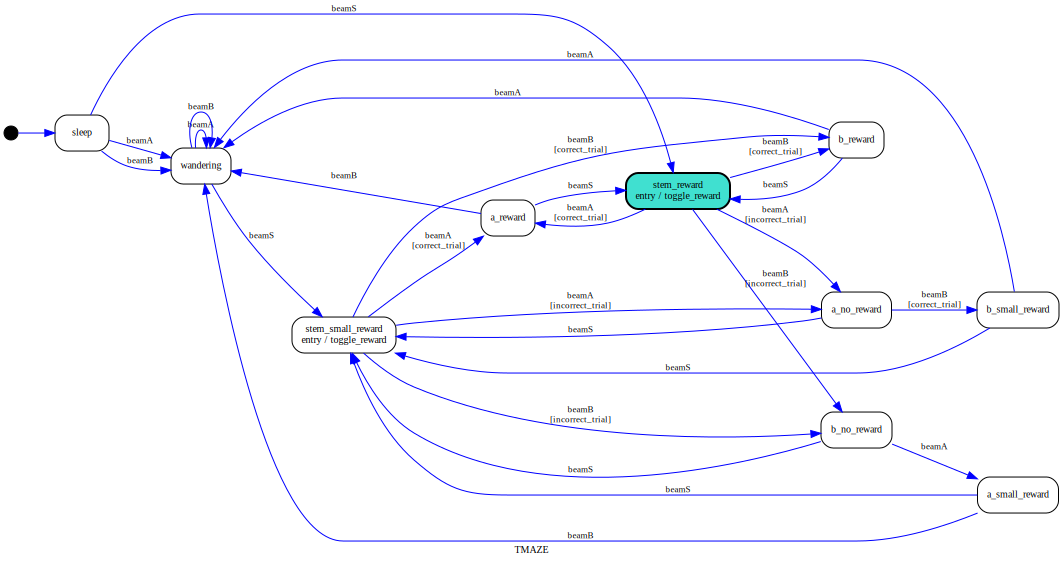

In [38]:
from statemachine import StateMachine, State

class TMAZE(StateMachine):

    sleep = State("sleep", initial=True)
    stem_reward= State("stem_reward", enter = "toggle_reward")
    stem_small_reward = State("stem_small_reward", enter = "toggle_reward")

    a_reward= State("a_reward")
    a_no_reward = State("a_no_reward")
    a_small_reward = State("a_small_reward")

    b_reward= State("b_reward")
    b_no_reward = State("b_no_reward")
    b_small_reward = State("b_small_reward")

    wandering = State("wandering")



    beamA =  ( stem_reward.to(a_reward, cond="correct_trial") | stem_reward.to(a_no_reward, cond="incorrect_trial") 
               | stem_small_reward.to(a_reward, cond="correct_trial") | stem_small_reward.to(a_no_reward, cond="incorrect_trial") 
               | b_reward.to(wandering) |  b_small_reward.to(wandering) | b_no_reward.to(a_small_reward)
               | sleep.to(wandering) | wandering.to.itself()
    )

    beamB =  ( stem_reward.to(b_reward, cond="correct_trial") | stem_reward.to(b_no_reward, cond="incorrect_trial") 
               | stem_small_reward.to(b_reward, cond="correct_trial") | stem_small_reward.to(b_no_reward, cond="incorrect_trial") 
               | a_reward.to(wandering) | a_small_reward.to(wandering)|  a_no_reward.to(b_small_reward, cond = "correct_trial")
               | sleep.to(wandering) | wandering.to.itself()
    )

    beamS =  ( a_reward.to(stem_reward) | a_no_reward.to(stem_small_reward) | a_small_reward.to(stem_small_reward)
               | b_reward.to(stem_reward) | b_no_reward.to(stem_small_reward) | b_small_reward.to(stem_small_reward) 
               | wandering.to(stem_small_reward) | sleep.to(stem_reward)
    )

    def __init__(self):
        super(TMAZE, self).__init__()
        self.target = None
        self.init = False

    def correct_trial(self, event_data):
        if self.target is None:
            self.target = event_data.target.id[0]
        return self.target == event_data.target.id[0]

    def incorrect_trial(self, event_data):
        if self.target is None:
            return False
        else:
            return self.target != event_data.target.id[0]
    
    def toggle_reward(self):
        if not self.init:
            self.init = True
            return
        else:
            self.target = 'b' if self.target=='a' else 'a'

t = TMAZE()
t.beamS()
t